In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import sys
import os

import numpy as np
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
from PIL import Image
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler


sys.path.append("../")


mpl.rcParams['figure.dpi'] = 120 # for high resolution figure in notebook

2023-04-24 21:27:24.409546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `keras` framework.


In [2]:
#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=7 #Number of classes for segmentation
num_images = 4981  #Total 1600 available

In [4]:
print("Images Shape:", images.shape)
print("Labels Shape:", labels.shape)

Images Shape: (4981, 256, 256, 3)
Labels Shape: (4981, 256, 256, 2)


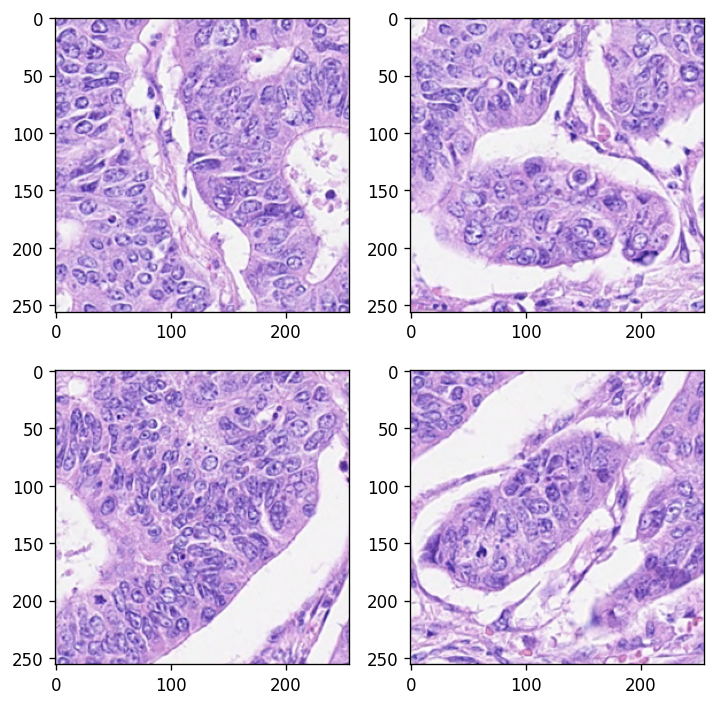

In [5]:
plt.figure(figsize=(7,7))
list=[20,60,21,61]
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i])
plt.show()

In [6]:
# separate the instance map label and classification map label
label_inst_map = labels[..., 0]
label_class_map = labels[..., 1]

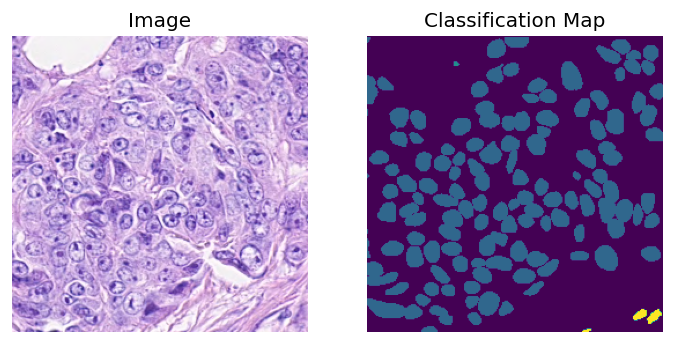

In [7]:
# this patch can be repeatedly executed to visualise a different patch!
rand_idx = np.random.randint(0, images.shape[0]) # select a random patch
patch_img = images[rand_idx] # 256x256x3
patch_lab = labels[rand_idx] # 256x256x2

# separate the instance map and classification map
patch_inst_map = patch_lab[..., 0]
patch_class_map = patch_lab[..., 1]

# visualise the data in a single plot
viz_dict = {"Image": patch_img, "Classification Map": patch_class_map}
fig = plt.figure(figsize=(7,10))
count = 1
for img_name, img in viz_dict.items():
  ax = plt.subplot(1,2, count)
  plt.imshow(img)
  plt.title(img_name)
  plt.axis("off")
  count += 1

In [8]:
print("Image data shape is: ", images.shape)
print("Mask data shape is: ", label_class_map.shape)
print("Max pixel value in image is: ", images.max())
print("Labels in the mask are : ", np.unique(label_class_map))

Image data shape is:  (4981, 256, 256, 3)
Mask data shape is:  (4981, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4 5 6]


In [9]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = label_class_map.shape  
label_class_map_reshaped = label_class_map.reshape(-1,1)

label_class_map_reshaped_encoded = labelencoder.fit_transform(label_class_map_reshaped)
label_class_map_encoded = label_class_map_reshaped_encoded.reshape(n, h, w)

np.unique(label_class_map_encoded)

/Users/yaoyutong/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6])

In [10]:
label_class_map_encoded = np.expand_dims(label_class_map_encoded, axis = 3)
print(label_class_map_encoded.shape)

(4981, 256, 256, 1)


In [11]:
#Normalize images
images = images /255.  #Can also normalize or scale using MinMax scaler

In [12]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, label_class_map_encoded, test_size = 0.2, random_state = 42)


In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3984, 256, 256, 3)
(3984, 256, 256, 1)
(997, 256, 256, 3)
(997, 256, 256, 1)


In [14]:
import tensorflow
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



In [16]:
print(y_train_cat.shape)
print(y_test_cat.shape)

(3984, 256, 256, 7)
(997, 256, 256, 7)


In [ ]:
#Building DeepLabV3
#https://github.com/nive927/Dubai-Satellite-Imagery-Multiclass-Segmentation/blob/main/01-03-DeepLabV3%2B_Model.ipynb

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow.keras
import tensorflow as tf

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tensorflow.keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [21]:
from tensorflow.keras.applications.resnet import ResNet50

IMAGE_SIZE = 256 # Assume square
NUM_CLASSES = 7

def DeeplabV3Plus(image_size, num_classes):
    model_input = tensorflow.keras.Input(shape=(image_size, image_size, 3))
    resnet50 = ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return tensorflow.keras.Model(inputs=model_input, outputs=model_output)

model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

2023-04-18 15:13:52.813011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model.save('./models/unet_with_deeplabv3+_backbone_100epochs.hdf5')

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model


In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape, n_classes=7)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [ ]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Epoch 1/20
249/249 [==============================] - 7901s 32s/step - loss: 0.4193 - accuracy: 0.8673 - val_loss: 0.8806 - val_accuracy: 0.8400
Epoch 2/20
249/249 [==============================] - 8074s 32s/step - loss: 0.2653 - accuracy: 0.9014 - val_loss: 0.5274 - val_accuracy: 0.8676
Epoch 3/20
249/249 [==============================] - 8063s 32s/step - loss: 0.2287 - accuracy: 0.9137 - val_loss: 0.2845 - val_accuracy: 0.9073
Epoch 4/20
249/249 [==============================] - 8027s 32s/step - loss: 0.2094 - accuracy: 0.9202 - val_loss: 0.2226 - val_accuracy: 0.9163
Epoch 5/20
249/249 [==============================] - 8019s 32s/step - loss: 0.1979 - accuracy: 0.9240 - val_loss: 0.2693 - val_accuracy: 0.9082
Epoch 6/20
249/249 [==============================] - 8060s 32s/step - loss: 0.1882 - accuracy: 0.9274 - val_loss: 0.2172 - val_accuracy: 0.9174
Epoch 7/20
249/249 [==============================] - 8046s 32s/step - loss: 0.1798 - accuracy: 0.9302 - val_loss: 0.2100 - val_ac

In [ ]:
model.save(r:'C\Users\Administrator\Desktop\Yutong_Yao\unet.hdf5')

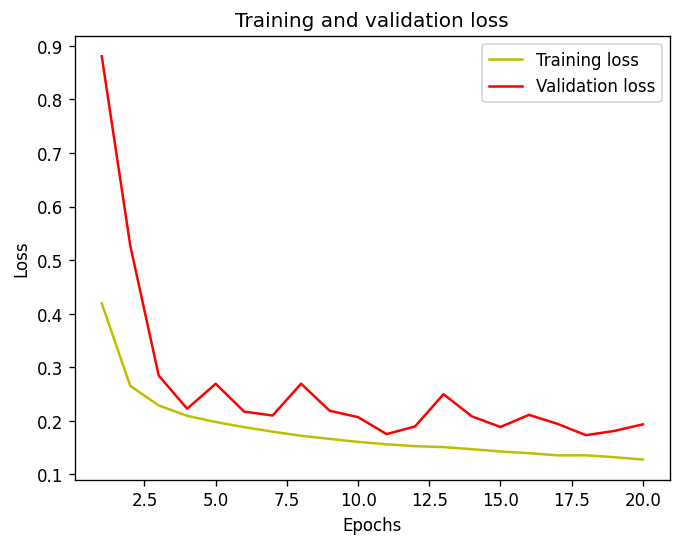

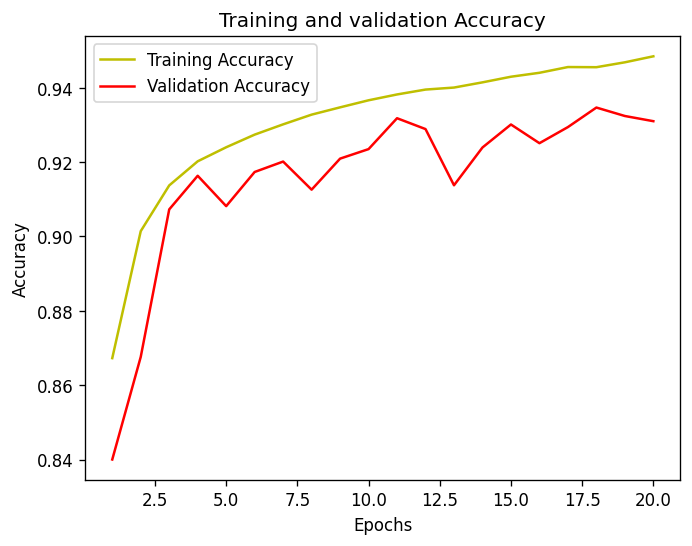

In [ ]:

###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
from keras.models import load_model
model_load = load_model('/Users/yaoyutong/Desktop/FYP/unet.hdf5', compile=False)


In [37]:
model=model_load

In [22]:
y_pred=model_load.predict(X_test)

32/32 [==============================] - 823s 26s/step


In [23]:
y_pred.shape

(997, 256, 256, 7)

In [24]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(997, 256, 256)

In [25]:
y_pred_argmax[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y_test2=y_test.reshape(997, 256, 256)

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# 计算F1-score(F1)
# 计算F1-score(F1)

def f1_accuracy(y_pred, y_true):
    # pred和label都是二维数组，表示预测和真实的像素类别
    # 返回一个0~1之间的浮点数，表示像素准确率
    # 计算混淆矩阵
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten())
    # 计算F1分数
    return f1_score(y_true.flatten(), y_pred.flatten(),average='macro')


f1_accuracy(y_pred_argmax, y_test2)

0.6076511666228137

In [31]:
"""
refer to https://github.com/jfzhang95/pytorch-deeplab-xception/blob/master/utils/metrics.py
"""
import numpy as np
__all__ = ['SegmentationMetric']
 
"""
confusionMetric  # 注意：此处横着代表预测值，竖着代表真实值，与之前介绍的相反
P\L     P    N
P      TP    FP
N      FN    TN
"""
class SegmentationMetric(object):
    def __init__(self, numClass):
        self.numClass = numClass
        self.confusionMatrix = np.zeros((self.numClass,)*2)
 
    def pixelAccuracy(self):
        # return all class overall pixel accuracy
        #  PA = acc = (TP + TN) / (TP + TN + FP + TN)
        acc = np.diag(self.confusionMatrix).sum() /  self.confusionMatrix.sum()
        return acc
 
    def classPixelAccuracy(self):
        # return each category pixel accuracy(A more accurate way to call it precision)
        # acc = (TP) / TP + FP
        classAcc = np.diag(self.confusionMatrix) / self.confusionMatrix.sum(axis=1)
        return classAcc # 返回的是一个列表值，如：[0.90, 0.80, 0.96]，表示类别1 2 3各类别的预测准确率
 
    def meanPixelAccuracy(self):
        classAcc = self.classPixelAccuracy()
        meanAcc = np.nanmean(classAcc) # np.nanmean 求平均值，nan表示遇到Nan类型，其值取为0
        return meanAcc # 返回单个值，如：np.nanmean([0.90, 0.80, 0.96, nan, nan]) = (0.90 + 0.80 + 0.96） / 3 =  0.89
 
    def meanIntersectionOverUnion(self):
        # Intersection = TP Union = TP + FP + FN
        # IoU = TP / (TP + FP + FN)
        intersection = np.diag(self.confusionMatrix) # 取对角元素的值，返回列表
        union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(self.confusionMatrix) # axis = 1表示混淆矩阵行的值，返回列表； axis = 0表示取混淆矩阵列的值，返回列表 
        IoU = intersection / union  # 返回列表，其值为各个类别的IoU
        mIoU = np.nanmean(IoU) # 求各类别IoU的平均
        return mIoU
 
    def genConfusionMatrix(self, imgPredict, imgLabel): # 同FCN中score.py的fast_hist()函数
        # remove classes from unlabeled pixels in gt image and predict
        mask = (imgLabel >= 0) & (imgLabel < self.numClass)
        label = self.numClass * imgLabel[mask] + imgPredict[mask]
        count = np.bincount(label, minlength=self.numClass**2)
        confusionMatrix = count.reshape(self.numClass, self.numClass)
        return confusionMatrix
 
    def Frequency_Weighted_Intersection_over_Union(self):
        # FWIOU =     [(TP+FN)/(TP+FP+TN+FN)] *[TP / (TP + FP + FN)]
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                np.diag(self.confusion_matrix))
        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU
 
 
    def addBatch(self, imgPredict, imgLabel):
        assert imgPredict.shape == imgLabel.shape
        self.confusionMatrix += self.genConfusionMatrix(imgPredict, imgLabel)
 
    def reset(self):
        self.confusionMatrix = np.zeros((self.numClass, self.numClass))
 
 
if __name__ == '__main__':
    imgPredict = y_pred_argmax # 可直接换成预测图片
    imgLabel = y_test2 # 可直接换成标注图片
    metric = SegmentationMetric(7) # 3表示有3个分类，有几个分类就填几
    metric.addBatch(imgPredict, imgLabel)
    pa = metric.pixelAccuracy()
    cpa = metric.classPixelAccuracy()
    mpa = metric.meanPixelAccuracy()
    mIoU = metric.meanIntersectionOverUnion()
    print('pa is : %f' % pa)
    print('cpa is :') # 列表
    print(cpa)
    print('mpa is : %f' % mpa)
    print('mIoU is : %f' % mIoU)


pa is : 0.931021
cpa is :
[0.9793524  0.15437797 0.71836134 0.61436485 0.58780506 0.23446431
 0.62657185]
mpa is : 0.559328
mIoU is : 0.477345


1/1 [==============================] - 1s 1s/step


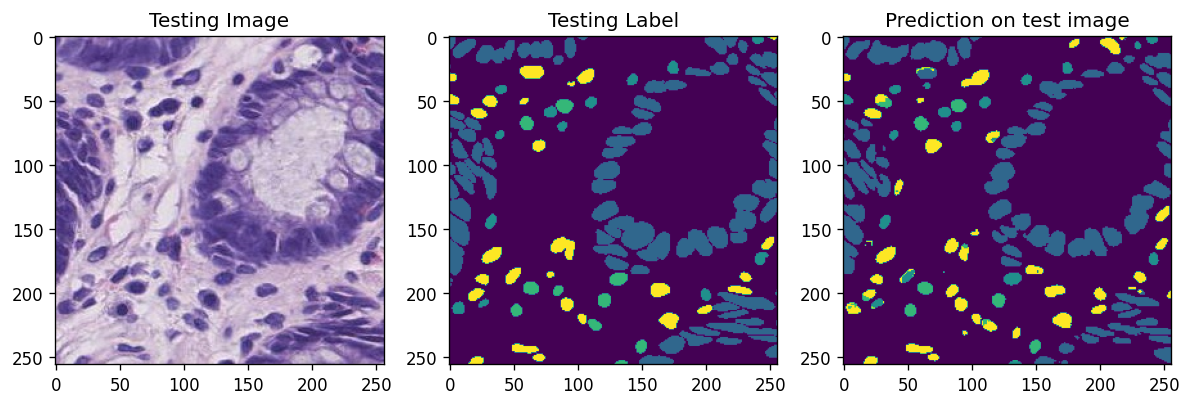

In [34]:
import random
test_img_number = 200
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
predicted_img=predicted_img.reshape(256,256,1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

1/1 [==============================] - 1s 583ms/step


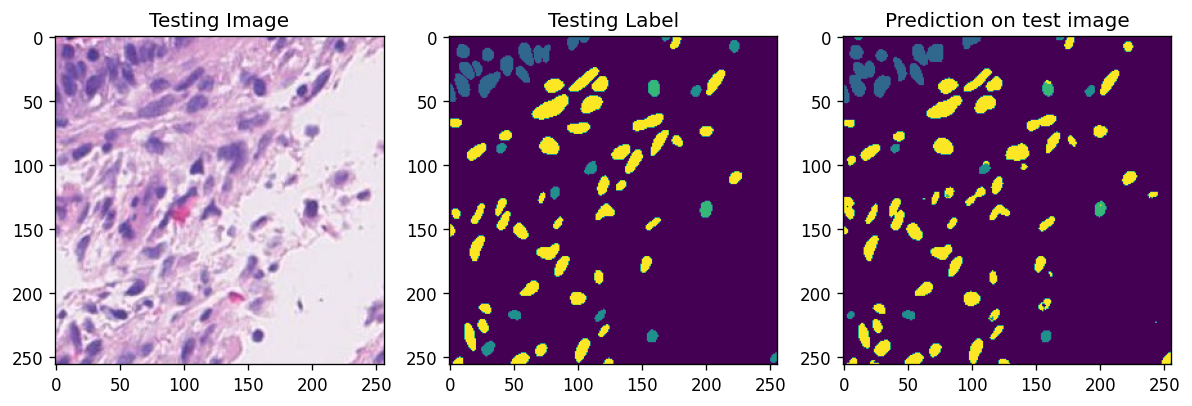

In [35]:
import random
test_img_number = 45
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
predicted_img=predicted_img.reshape(256,256,1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

1/1 [==============================] - 0s 487ms/step


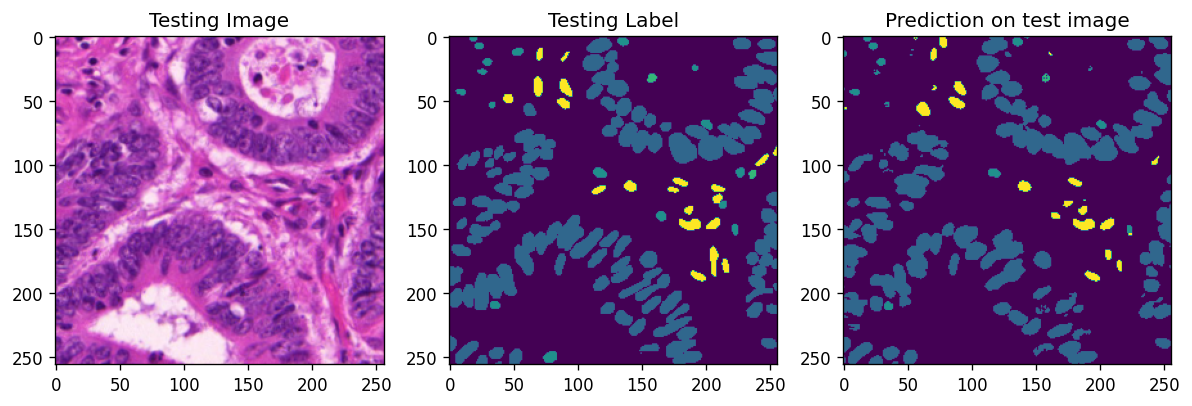

In [38]:
import random
test_img_number = 80
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
predicted_img=predicted_img.reshape(256,256,1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [ ]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 7
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.46020535


1/1 [==============================] - 1s 772ms/step


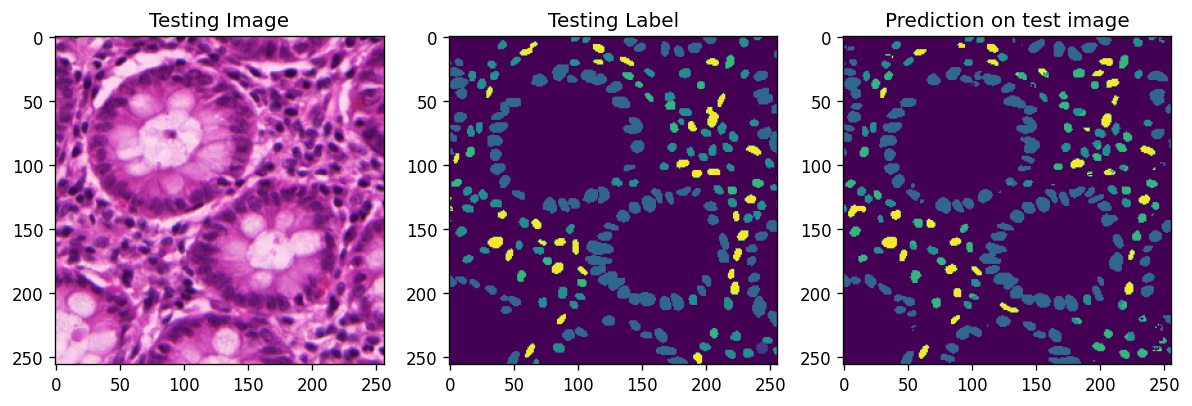

In [114]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
predicted_img=predicted_img.reshape(256,256,1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

1/1 [==============================] - 1s 792ms/step


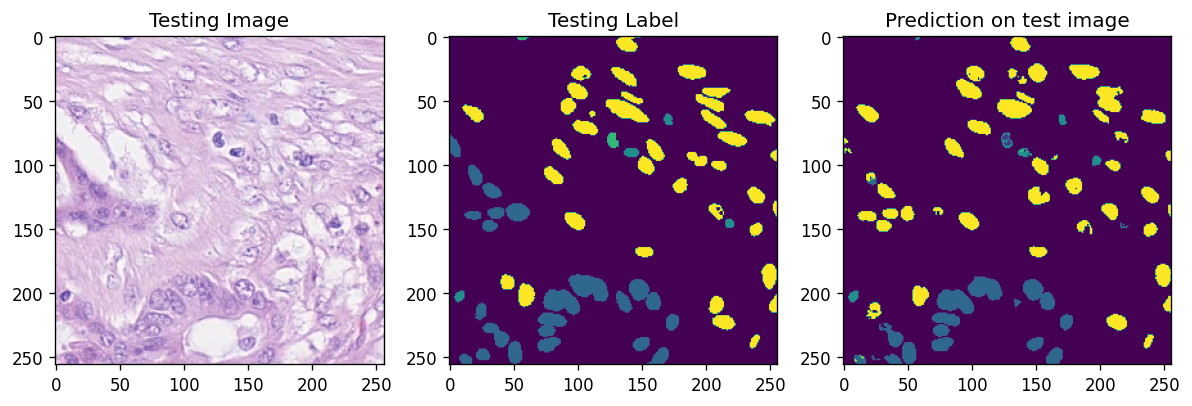

In [115]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
predicted_img=predicted_img.reshape(256,256,1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

1/1 [==============================] - 1s 780ms/step


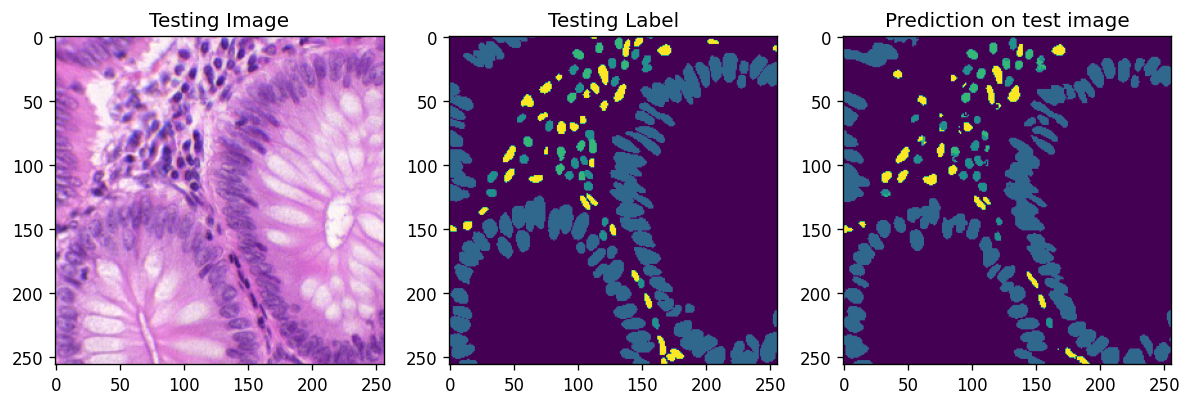

In [116]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
predicted_img=predicted_img.reshape(256,256,1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [ ]:
# 计算混淆矩阵
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


In [ ]:
y_pred_argmax=y_pred_argmax.reshape(997, 256, 256,1)
_fast_hist(y_test,y_pred_argmax,7)

array([[53752157,     3999,   788149,    52683,    26099,     2970,
          259353],
       [   52851,    12058,      480,     6490,      882,      835,
            4511],
       [ 1750433,      100,  4870409,    13417,     5166,       32,
          140329],
       [  181248,     4327,    33045,   745936,   144933,     1495,
          103174],
       [   52639,      376,    15609,    32633,   209037,     1494,
           43835],
       [   40454,     1208,      283,     3391,     4716,    16039,
            2316],
       [  646262,      863,    56029,    12938,    14833,      173,
         1226703]], dtype=int64)